In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
df_raw = pd.read_csv('../../Deeplearning_dataset/BostonHousing.csv')

In [3]:
df_raw

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [4]:
X = df_raw.drop('medv', axis=1)
y = df_raw['medv']

In [5]:
# 학습 데이터와 테스트 데이터를 일정 비율로 나누기
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2022)

# 학습 데이터
print(f"x_train의 크기: {x_train.shape}")
print(f"y_train의 크기: {y_train.shape}\n")

# 테스트 데이터
print(f"x_test의 크기: {x_test.shape}")
print(f"y_test의 크기: {y_test.shape}")

x_train의 크기: (354, 13)
y_train의 크기: (354,)

x_test의 크기: (152, 13)
y_test의 크기: (152,)


In [6]:
# 학습 데이터 Scaling(scale이 다른 데이터들을 비슷한 scale로 맞춰주기 위하여)
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test) # train 데이터 기준으로 test 데이터를 scaling

# array => tensor
x_train_tensor = torch.FloatTensor(x_train_scale)
y_train_tensor = torch.FloatTensor(y_train.values)

x_test_tensor = torch.FloatTensor(x_test_scale)
y_test_tensor = torch.FloatTensor(y_test.values)

In [7]:
# 학습 데이터 배치화 시키기
train_data = data_utils.TensorDataset(x_train_tensor, y_train_tensor)

dataloader = DataLoader(train_data, batch_size=100, shuffle=True,
                       drop_last=False) # 마지막에 남는 54개도 그대로 반환

# 배치화된 데이터 확인
for batch_idx, datas in enumerate(dataloader):
    print(f"batch_index: {batch_idx}")
    print(datas[0].shape)       # x_train
    print(datas[1].shape, '\n') # y_train

batch_index: 0
torch.Size([100, 13])
torch.Size([100]) 

batch_index: 1
torch.Size([100, 13])
torch.Size([100]) 

batch_index: 2
torch.Size([100, 13])
torch.Size([100]) 

batch_index: 3
torch.Size([54, 13])
torch.Size([54]) 



## Model

In [8]:
# parameter 정의
input_size = X.shape[-1]
output_size = 1
learning_rate = 0.01
num_epochs = 50

In [9]:
# model 생성
model = nn.Linear(in_features=input_size, out_features=output_size)

In [10]:
# 손실함수 정의
criterion = nn.MSELoss()
# Optimizer 정의
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

## Training

In [11]:
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        # Batch 학습
        model.train()
        optimizer.zero_grad() # gradient 초기화
        
        y_pred = model(x_batch).reshape(-1) # 예측값
        loss_train = criterion(y_pred, y_batch) # loss
        
        loss_train.backward() # graident 계산
        optimizer.step() # weight 업데이트
        
    # Validation
    model.eval()
        
    y_test_pred = model(x_test_tensor).reshape(-1)
    loss_test = criterion(y_test_pred, y_test_tensor)
    
    # epoch 마다 train, test loss 저장
    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    
    print(f"epoch: [{epoch+1}] Loss_train: {loss_train:.2f}, Loss_test: {loss_test:.2f}")

epoch: [1] Loss_train: 487.48, Loss_test: 455.92
epoch: [2] Loss_train: 471.45, Loss_test: 391.15
epoch: [3] Loss_train: 354.28, Loss_test: 336.31
epoch: [4] Loss_train: 355.15, Loss_test: 289.86
epoch: [5] Loss_train: 281.03, Loss_test: 249.54
epoch: [6] Loss_train: 269.21, Loss_test: 214.52
epoch: [7] Loss_train: 194.37, Loss_test: 185.41
epoch: [8] Loss_train: 162.55, Loss_test: 161.04
epoch: [9] Loss_train: 146.19, Loss_test: 140.90
epoch: [10] Loss_train: 164.22, Loss_test: 122.55
epoch: [11] Loss_train: 90.22, Loss_test: 107.64
epoch: [12] Loss_train: 125.27, Loss_test: 94.34
epoch: [13] Loss_train: 86.43, Loss_test: 83.42
epoch: [14] Loss_train: 90.18, Loss_test: 74.46
epoch: [15] Loss_train: 73.47, Loss_test: 66.51
epoch: [16] Loss_train: 55.90, Loss_test: 60.01
epoch: [17] Loss_train: 36.44, Loss_test: 54.60
epoch: [18] Loss_train: 73.10, Loss_test: 49.46
epoch: [19] Loss_train: 50.32, Loss_test: 45.37
epoch: [20] Loss_train: 45.52, Loss_test: 41.94
epoch: [21] Loss_train: 30.

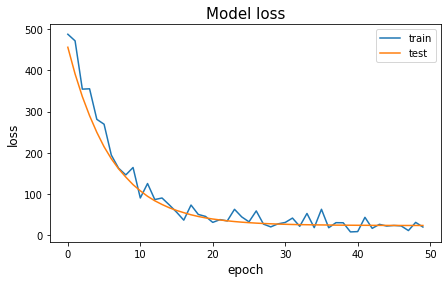

In [15]:
# epoch에 따른 loss 변화

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(range(num_epochs), train_loss, label='train')
ax.plot(range(num_epochs), test_loss, label='test')
ax.legend()

ax.set_title('Model loss', fontsize=15)
ax.set_xlabel('epoch', fontsize=12)
ax.set_ylabel('loss', fontsize=12)

plt.show()